In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Define constants
mass = 39.95*1.68*10**(-27)
epsilon = 119.8/1.381*10**(-23)
sigma = 3.405 #angstrom
Electric_Charge = 0.0
Epsilon_0 = 8.85*10**(-12)*sigma*epsilon*Electric_Charge**2
N_Particles = 32

#User input
rho = 1.2 #units of sigma**-3, N*m/L^3
Temperature = 0.5
Box_Size = (N_Particles/rho)**(1/3)
Lattice_Size = Box_Size/3
#Box_Size = 100
#Lattice_Size = 3.12354
Particle_Charge = -1*Electric_Charge
E_Field = 0.2

In [3]:
#Functions

def Force(A_Position,B_Position):
    Sequence_Polarity = np.array(A_Position>B_Position)*2 -1
    Image_Polarity = np.array(np.power((A_Position-B_Position),2)>(Box_Size/2)**(2))
    Distances = (Image_Polarity*Box_Size-np.abs(A_Position-B_Position))
    Distance = np.sum(np.power(Distances,2))**(0.5)
    Lennard_Jones_pot = 4*(Distance**(-6) - Distance**(-12))
    Total_Force = 4*(6/(Distance)**(7) - 12/(Distance)**(13))
    Directions = Distances*Sequence_Polarity
    Forces = (Directions/Distance)*Total_Force
    Forces[2] += Particle_Charge*E_Field
    return Forces, Lennard_Jones_pot, Distance, Total_Force

#Maybe write to file multiple times and get values from this file to get <n(r)>
#Or run code again and use Distance_List1, Distance_List2 etc
Distance_List = []
def Dist_Pair_Corr(Distance):
    Distance_List.append(Distance)

Delta_r = Lattice_Size/20
Pair_Corr_Bins = np.arange(0, 3*Lattice_Size/2, Delta_r)
Pair_Corr_r_List = []
#Calculated for each [r, r+delta_r]
#Distance here is every value of Pair_Corr_Bins
def Pair_Corr_function(Average_n, Distance_r):
    Pair_Corr_r = 2*(Lattice_Size*3)**3/((N_Particles*(N_Particles-1)))*Average_n/(4*np.pi*Distance_r**2*Bin_Size)
    Pair_Corr_r_List.append(Pair_Corr_r)
    return Pair_Corr_r_List

Pressure_LJ_Pot_list = []
def Average_LJ_Pot(Distance, Total_Force):
    Pressure_LJ_Pot = Distance*Total_Force
    Pressure_LJ_Pot_list.append(Pressure_LJ_Pot)
    return Pressure_LJ_Pot_list


#Particles relaxation


def Relaxation(Iterations, pos):


    #Fiducial extreme values of lambda. Inside these we assume the system is in thermal equilibrium
    lambda_min = 0.9
    lambda_max = 1.1


    Dimensions = 3

    Historic_Positions = np.zeros((N_Particles,Dimensions,Iterations))
    Historic_Velocities = np.zeros((N_Particles,Dimensions,Iterations))

    Positions = pos[:,:3]
    Velocities = pos[:,3:]
    Historic_Positions[:,:,0] = Positions
    Historic_Velocities[:,:,0] = Velocities

    Energy = np.zeros((Iterations,3))

    Timestep = 0.0001


    for t in range(Iterations-1):


        Energy[t,0] = np.sum(0.5*Velocities[:,:]**2)


        Forces = np.zeros((N_Particles,Dimensions))
        Pot_En = np.zeros((N_Particles,Dimensions))
        for i in range(N_Particles):
            for j in range(N_Particles):
                if (i != j):
                    Added_Forces, LJ_En, Distance, Total_Force = Force(Positions[i,:],Positions[j,:])
                    Forces[i] += Added_Forces
                    Pot_En[i] += LJ_En
                    if i < j and t in range(Iterations-10, Iterations-5):
                        Dist_Pair_Corr(Distance)
                        Pressure_Value = Average_LJ_Pot(Distance, Total_Force)

        Energy[t,1] = -np.sum(Pot_En)
        Energy[t,2] = Energy[t,0] + Energy[t,1]

        Positions = (Historic_Positions[:,:,t] + Velocities*Timestep + Forces*(Timestep**2)/2)%Box_Size
        Historic_Positions[:,:,t+1] = Positions
        if (t>0):
            Velocities = Historic_Velocities[:,:,t-1] + (Historic_Forces+Forces)*(Timestep/2)
            Historic_Velocities[:,:,t] = Velocities
        Historic_Forces = Forces
    
    
        if t%2 == 0:
            lmbd = np.sqrt((N_Particles -1)*3*Temperature/Energy[t,0])
            
        if lmbd < lambda_min or lmbd > lambda_max:
            Historic_Velocities[:,:,t] = Velocities * lmbd

        if (t%100) == 0 and t>0:
            print(t)
            print('lambda = ', lmbd)
    return Historic_Velocities[:,:,t], Historic_Positions[:,:,t]

In [4]:
#Positions of atoms
pos = np.zeros((N_Particles,6))


unit_cell = np.array([[0,0,0],
                       [0,Lattice_Size,Lattice_Size],
                       [Lattice_Size,0,Lattice_Size],
                       [Lattice_Size,Lattice_Size,0]])



#Number of cells
Nx = 2
Ny = 2
Nz = 2
Step = 0
for i in range(Nx):
    for j in range(Ny):
        for k in range(Nz):
            pos[Step:Step+4,:3] = (unit_cell + np.tile([i,j,k],4).reshape(4,3))
            Velocities = np.zeros((4,3))
            for l in range(int(np.size(unit_cell)/3)):
                vx = np.random.normal(0, np.sqrt(Temperature))
                vy = np.random.normal(0, np.sqrt(Temperature))
                vz = np.random.normal(0, np.sqrt(Temperature))
                Velocities[l,:] = np.array([vx,vy,vz])
                
            
            pos[Step:Step+4,3:] = Velocities
            Step += int(np.size(unit_cell)/3)


In [5]:
#Check if any particle is initialised outside the periodic box

for n in range(N_Particles):
    for p in range(Nx):
        if pos[n, p] >= Box_Size or pos[n,p] < 0:
            print('particle_' , n, '  axis_' , p)
for n in range(N_Particles):
    for m in range(N_Particles):
        if m != n:
            if pos[n,0] == pos[m,0] and pos[n,1] == pos[m,1] and pos[n,2] == pos[m,2]:
                print(n , m)

In [6]:
Iterations = 5000

Velocities, Positions = Relaxation(Iterations, pos)

100
lambda =  0.6281686184683697
200
lambda =  0.8075694458838958
300
lambda =  0.8839213388992722
400
lambda =  0.9740122442071456
500
lambda =  0.8965944792435145
600
lambda =  0.9216009291884276
700
lambda =  0.9821207989334105
800
lambda =  0.9534197510691189
900
lambda =  1.0063279212393648
1000
lambda =  0.9301203340760723
1100
lambda =  0.9899377604979316
1200
lambda =  0.8927183033754175
1300
lambda =  0.9917961715514153
1400
lambda =  0.9775215075200112
1500
lambda =  1.08251633741815
1600
lambda =  1.0098385100830276
1700
lambda =  0.9915623099167927
1800
lambda =  1.0377047485732858
1900
lambda =  0.9168235486233488
2000
lambda =  0.9118250384755989
2100
lambda =  0.9123440410923068
2200
lambda =  0.9963778854243343
2300
lambda =  0.9971211560214728
2400
lambda =  1.1066771640339306
2500
lambda =  1.1084953450087518
2600
lambda =  0.9978610204441052
2700
lambda =  0.8996062226289636
2800
lambda =  0.8984373176905184
2900
lambda =  0.9981022601049603
3000
lambda =  0.99853330

In [7]:
now_pos = np.array([Velocities])

print(Velocities, Positions)

[[-0.34026251  0.77536206  0.52152571]
 [ 1.38411233  0.88310061  0.13455264]
 [-1.45835948 -0.57388459 -0.14058512]
 [ 0.76292702 -2.07457463  1.29249179]
 [ 0.84364678 -1.76667345  1.90773547]
 [ 0.53700487  1.31615931  0.66445434]
 [ 0.40848663 -0.01890719 -0.50841585]
 [ 1.10005989  0.60430398 -0.06792136]
 [ 1.38299253 -0.33634653  0.1597054 ]
 [-1.06642495  0.07180093  1.05044026]
 [ 0.21412569 -2.18758172  1.62241776]
 [-0.91038531 -0.95426443  0.46380545]
 [-1.61715451 -0.23995695 -1.6244209 ]
 [-2.56602066  0.53810361 -0.2842591 ]
 [ 0.59385196 -0.69551878 -0.20537103]
 [ 0.75697128  0.74502082 -2.85779753]
 [-1.14984008  0.61044962 -1.24556174]
 [ 1.27332866  1.53174136  0.57848108]
 [ 1.25824263  0.06120103  0.71978868]
 [-2.49912863  0.83541843  0.37532219]
 [ 0.94440704  0.32594416  0.68413903]
 [ 0.00584131 -0.56228778 -0.50072387]
 [ 1.17370603 -1.23257772 -0.38488856]
 [ 1.0172317  -0.06248476  2.63775642]
 [-0.50013803 -0.61665457 -0.33155325]
 [ 1.67753726 -0.01002799

In [8]:
Iterations = 20000



Dimensions = 3

Historic_Positions = np.zeros((N_Particles,Dimensions,Iterations))
Historic_Velocities = np.zeros((N_Particles,Dimensions,Iterations))

# Positions = pos[:,:3]
# Velocities = pos[:,3:]
Historic_Positions[:,:,0] = Positions
Historic_Velocities[:,:,0] = Velocities

Energy = np.zeros((Iterations,3))

Timestep = 0.0001


for t in range(Iterations-1):
 
    Energy[t,0] = np.sum(0.5*Velocities[:,:]**2)
    
    Forces = np.zeros((N_Particles,Dimensions))
    Pot_En = np.zeros((N_Particles,Dimensions))
    for i in range(N_Particles):
        for j in range(N_Particles):
            if (i != j):
                Added_Forces, LJ_En, Distance, Total_Force = Force(Positions[i,:],Positions[j,:])
                Forces[i] += Added_Forces
                Pot_En[i] += LJ_En
                if i < j and t in range(Iterations-10, Iterations-5):
                    Dist_Pair_Corr(Distance)
                    Pressure_Value = Average_LJ_Pot(Distance, Total_Force)
    
    Energy[t,1] = -np.sum(Pot_En)
    Energy[t,2] = Energy[t,0] + Energy[t,1]
        
    Positions = (Historic_Positions[:,:,t] + Velocities*Timestep + Forces*(Timestep**2)/2)%Box_Size
    Historic_Positions[:,:,t+1] = Positions
    if (t>0):
        Velocities = Historic_Velocities[:,:,t-1] + (Historic_Forces+Forces)*(Timestep/2)
        Historic_Velocities[:,:,t] = Velocities
    Historic_Forces = Forces

    
    if (t%100) == 0 and t>0:
        print(t)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

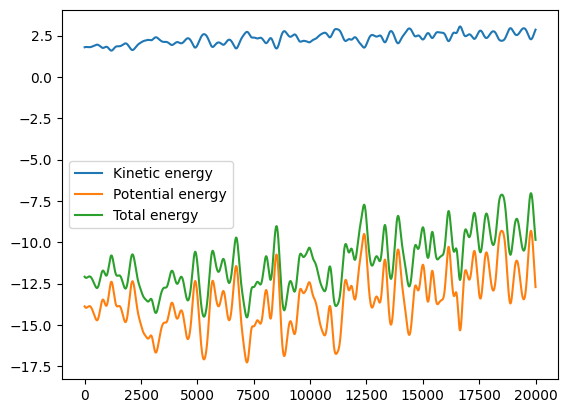

In [9]:
start_plot = 0

end_plot = -1

plt.plot(Energy[start_plot:end_plot,0]/N_Particles, label = 'Kinetic energy')
plt.plot(Energy[start_plot:end_plot,1]/N_Particles, label = 'Potential energy')
plt.plot(Energy[start_plot:end_plot,2]/N_Particles, label = 'Total energy')
# plt.yscale('log')
plt.legend()


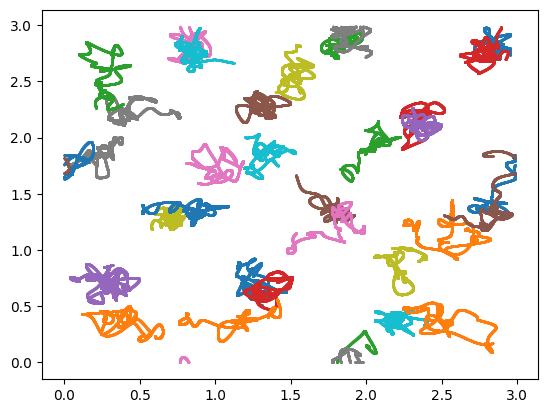

In [10]:
for m in range(N_Particles):
    plt.scatter(Historic_Positions[m,0,start_plot:], Historic_Positions[m,2,start_plot:], s = 0.1)


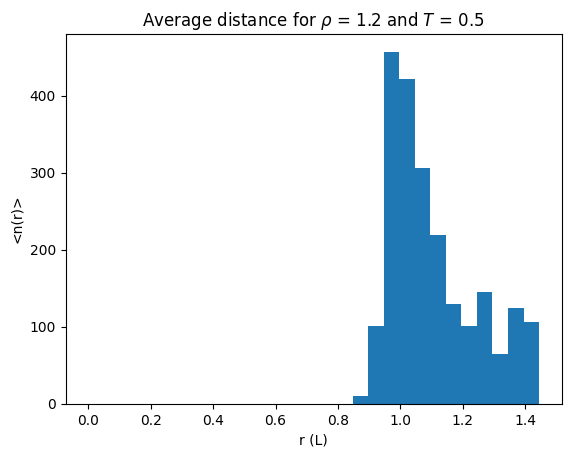

In [11]:
Avg_n = plt.hist(Distance_List, bins = Pair_Corr_Bins)
plt.xlabel('r (L)')
plt.ylabel('<n(r)>')
plt.title(r'Average distance for $\rho$ = {}'.format(rho) + r' and $T$ = {}'.format(Temperature))
plt.show()


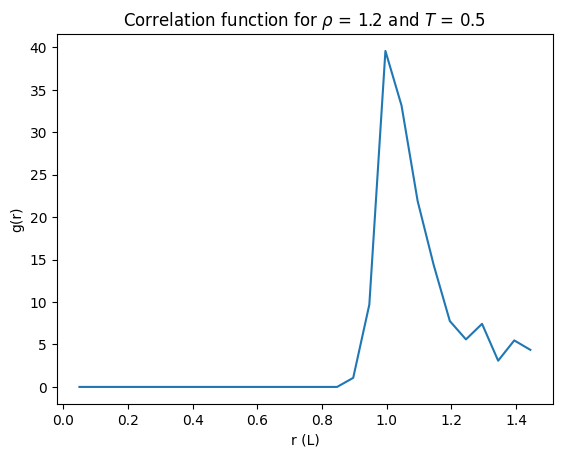

In [12]:
Pair_Corr_r_List = []
def Pair_Corr_function(Average_n, Distance_r):
    Pair_Corr_r = 2*(Lattice_Size*3)**3/((N_Particles*(N_Particles-1)))*Average_n/(4*np.pi*Distance_r**2*Delta_r)
    Pair_Corr_r_List.append(Pair_Corr_r)
    return Pair_Corr_r_List

for Average_n, Distance_r in zip(Avg_n[0], Pair_Corr_Bins[1:]):
    Pair_Corr_function(Average_n, Distance_r)


plt.plot(Pair_Corr_Bins[1:], Pair_Corr_r_List)
plt.xlabel('r (L)')
plt.ylabel('g(r)')
plt.title(r'Correlation function for $\rho$ = {}'.format(rho) + r' and $T$ = {}'.format(Temperature))
plt.show()


In [13]:
#Pressure
#To get average over multiple initial conditions, save the Pressure_Value_Total ssomewhere
# and run the simulation multiple times
Pressure_Value_Total = np.sum(Pressure_Value)/len(Pressure_Value)
print(Pressure_Value_Total)
Pressure = 1 - (3*N_Particles)*0.5*Pressure_Value_Total
print(Pressure)

-6.399376719350185
308.17008252880885


In [16]:
%matplotlib notebook

<IPython.core.display.Javascript object>


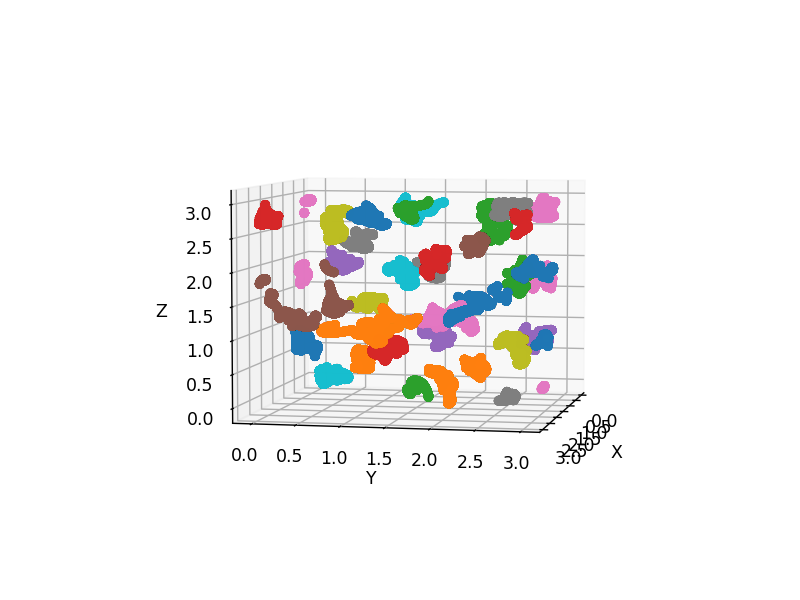

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for l in range(N_Particles):
    ax.scatter(Historic_Positions[l,0,0:],Historic_Positions[l,1,0:], Historic_Positions[l,2,0:])

ax.view_init(elev=8., azim=60.)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()